## Multi-Modal Model (with Grad-CAM)

A multi-modal model was built by combining **tabular features** with **satellite imagery** to capture both property attributes and neighborhood context.

- Tabular features processed through a regression model  
- Satellite images encoded using a pretrained CNN  
- Image embeddings concatenated with tabular features for final prediction  
- Target variable: **log-transformed price**



In [ ]:
import os
import cv2
import timm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

In [ ]:
df=pd.read_csv(r"/content/train(1)(train(1)).csv")
print(df.shape,df.columns)

(16209, 21) Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


## Same Feature Engineering as the "Only Tabular Model"

Identical feature engineering steps were applied to maintain consistency with the tabular-only model.


In [ ]:
df["log_price"] = np.log1p(df["price"])
df["total_sqft"] = df["sqft_above"] + df["sqft_basement"]
df["total_sqft"] = df["total_sqft"].clip(0, df["total_sqft"].quantile(0.99))
df["has_basement"] = (df["sqft_basement"] > 0).astype(int)
df["house_age"] = 2015 - df["yr_built"]

df["was_renovated"] = (df["yr_renovated"] > 0).astype(int)

df["years_since_renovation"] = np.where(
    df["yr_renovated"] > 0,
    2015 - df["yr_renovated"],
    df["house_age"]
)
df["bedrooms_per_sqft"] = df["bedrooms"] / (df["sqft_living"] + 1)
df["relative_living_size"] = df["sqft_living"] / (df["sqft_living15"] + 1)
df["relative_living_size"] = df["relative_living_size"].clip(0, 3)
df["floors_cat"] = df["floors"].astype(str)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
coords = df[["lat", "long"]].values
inertias = []
K = range(2, 16)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coords)
    inertias.append(kmeans.inertia_)

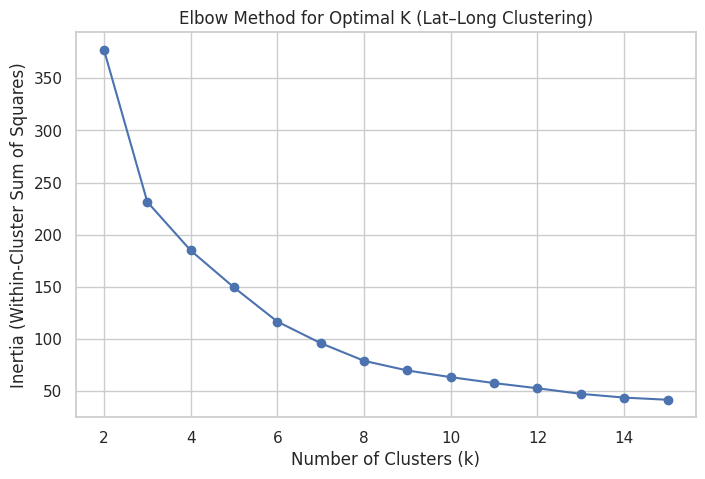

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(K, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K (Lat–Long Clustering)")
plt.grid(True)
plt.show()

In [ ]:
optimal_k = 7

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
df["location_cluster"] = kmeans_final.fit_predict(coords)

In [ ]:
df["floors_cat"] = df["floors_cat"].astype("category").cat.codes
df["location_cluster"] = df["location_cluster"].astype("category").cat.codes

In [ ]:
df.drop(['date','sqft_above', 'sqft_basement','yr_built', 'yr_renovated', 'sqft_lot15','floors','price'],inplace=True,axis=1)

In [ ]:
df['zip_sqft_mean']    = df.groupby('zipcode')['sqft_living'].transform('mean')
df['zip_sqft_median']  = df.groupby('zipcode')['sqft_living'].transform('median')

df['sqft_per_room'] = df['sqft_living'] / (df['bedrooms'] + df['bathrooms'] + 1)
df['sqft_ratio'] = df['sqft_living'] / (df['sqft_living15'] + 1)
df['lat_long_product'] = df['lat'] * df['long']

# Age interactions
df['age_sqft_interaction'] = df['house_age'] * df['sqft_living']

# Grade interactions
df['grade_sqft'] = df['grade'] * df['sqft_living']

# Room ratio
df['bath_per_bed'] = df['bathrooms'] / (df['bedrooms'] + 1)
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
print(df.shape)
df.columns

(16209, 31)


Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
       'view', 'condition', 'grade', 'zipcode', 'lat', 'long', 'sqft_living15',
       'log_price', 'total_sqft', 'has_basement', 'house_age', 'was_renovated',
       'years_since_renovation', 'bedrooms_per_sqft', 'relative_living_size',
       'floors_cat', 'location_cluster', 'zip_sqft_mean', 'zip_sqft_median',
       'sqft_per_room', 'sqft_ratio', 'lat_long_product',
       'age_sqft_interaction', 'grade_sqft', 'bath_per_bed'],
      dtype='object')


### Grad-CAM Interpretability
Grad-CAM was applied to the image encoder to visualize influential regions.  
The model primarily attends to **road networks, vegetation, and built-up density**, indicating meaningful spatial learning.

In [ ]:
# ---------------------------
# CONFIGURATION
# ---------------------------
class Config:
    SEED = 42
    IMG_SIZE = 224
    BATCH_SIZE = 32
    EPOCHS = 8  # Increased slightly for better learning
    LEARNING_RATE = 3e-4

# Set seed
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)


# Remove extreme outliers (helps model learn better)
price_q1 = df['price'].quantile(0.01)
price_q99 = df['price'].quantile(0.99)
df = df[(df['price'] >= price_q1) & (df['price'] <= price_q99)]

print(f"Price range after cleaning: ${df['price'].min():,.0f} to ${df['price'].max():,.0f}")

# Log transform
df["log_price"] = np.log1p(df["price"])

# Normalize to help training
price_mean = df["log_price"].mean()
price_std = df["log_price"].std()
df["target"] = (df["log_price"] - price_mean) / price_std

print(f"Target stats - Mean: {price_mean:.4f}, Std: {price_std:.4f}")

# Split
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=Config.SEED)
print(f"Train: {df_train.shape}, Valid: {df_valid.shape}")

# ---------------------------
# ENHANCED DATASET FOR GOOGLE MAPS
# ---------------------------
IMG_DIR = "/kaggle/input/google-images/google_images"

class GoogleMapsDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_train=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{int(row['id'])}.png")

        img = cv2.imread(img_path)

        if img is None:
            # Create a more meaningful default image
            img = self.create_default_google_maps_image()
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Basic augmentation for training
            if self.is_train and np.random.random() > 0.5:
                # Brightness/contrast adjustment
                alpha = np.random.uniform(0.9, 1.1)
                beta = np.random.randint(-20, 20)
                img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

        # Resize
        img = cv2.resize(img, (Config.IMG_SIZE, Config.IMG_SIZE))

        if self.transform:
            img = self.transform(img)

        y = torch.tensor(row["target"], dtype=torch.float32)
        return img, y, row["id"]

    def create_default_google_maps_image(self):
        """Create synthetic Google Maps-like image"""
        size = Config.IMG_SIZE
        img = np.full((size, size, 3), 200, dtype=np.uint8)  # Light gray

        # Add some roads
        for _ in range(3):
            cv2.line(img,
                    (np.random.randint(0, size), np.random.randint(0, size)),
                    (np.random.randint(0, size), np.random.randint(0, size)),
                    (100, 100, 100), np.random.randint(2, 5))

        # Add some building-like rectangles
        for _ in range(5):
            x = np.random.randint(0, size-50)
            y = np.random.randint(0, size-50)
            w = np.random.randint(30, 80)
            h = np.random.randint(30, 80)
            cv2.rectangle(img, (x, y), (x+w, y+h),
                         (np.random.randint(150, 220),
                          np.random.randint(150, 200),
                          np.random.randint(150, 200)), -1)

        return img

# ---------------------------
# TRANSFORMS
# ---------------------------
train_transform = T.Compose([
    T.ToPILImage(),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

valid_transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# ---------------------------
# DATA LOADERS
# ---------------------------
train_ds = GoogleMapsDataset(df_train, IMG_DIR, train_transform, is_train=True)
valid_ds = GoogleMapsDataset(df_valid, IMG_DIR, valid_transform, is_train=False)

train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE,
                         shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=Config.BATCH_SIZE,
                         shuffle=False, num_workers=2, pin_memory=True)

# ---------------------------
# BETTER MODEL FOR GRAD-CAM
# ---------------------------
class BetterGradCAMModel(nn.Module):
    def __init__(self, backbone_name="resnet34"):
        super().__init__()
        # ResNet34 is good for Grad-CAM - clear feature hierarchy
        self.backbone = timm.create_model(backbone_name, pretrained=True,
                                         features_only=True)

        # Get feature dimensions
        features = self.backbone(torch.randn(1, 3, Config.IMG_SIZE, Config.IMG_SIZE))
        self.last_feature_dim = features[-1].shape[1]

        # Simple regressor
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Sequential(
            nn.Linear(self.last_feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

        # Store for Grad-CAM
        self.features = None
        self.gradients = None

        # Register hooks on the last convolutional block
        self._register_hooks()

    def _register_hooks(self):
        """Register hooks for Grad-CAM on last conv layer"""
        def forward_hook(module, input, output):
            self.features = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook the last conv layer
        if hasattr(self.backbone, 'stem'):
            target_layer = self.backbone.stem
        else:
            # For ResNet, hook the last conv in the last block
            target_layer = self.backbone.layer4[-1].conv2

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def forward(self, x):
        features = self.backbone(x)[-1]  # Take last feature map
        pooled = self.global_pool(features).flatten(1)
        output = self.regressor(pooled)
        return output

    def get_gradcam(self, target=None):
        """Generate Grad-CAM heatmap"""
        if self.features is None or self.gradients is None:
            return None

        # Detach from graph
        features = self.features.detach()
        gradients = self.gradients.detach()

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)

        # Weighted combination of feature maps
        cam = torch.sum(weights * features, dim=1, keepdim=True)
        cam = F.relu(cam)  # Apply ReLU

        # Normalize to [0, 1]
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze()

# ---------------------------
# TRAINING WITH BETTER LOSS
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = BetterGradCAMModel("resnet34").to(device)

# Use SmoothL1Loss (Huber) - more robust than MSE
criterion = nn.SmoothL1Loss(beta=1.0)
optimizer = torch.optim.AdamW(model.parameters(),
                            lr=Config.LEARNING_RATE,
                            weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=Config.LEARNING_RATE,
    epochs=Config.EPOCHS,
    steps_per_epoch=len(train_loader)
)

# ---------------------------
# IMPROVED TRAINING LOOP
# ---------------------------
best_val_loss = float('inf')
history = {'train': [], 'val': [], 'val_rmse': []}

print("\nStarting training...")
for epoch in range(Config.EPOCHS):
    # Training
    model.train()
    train_loss = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{Config.EPOCHS} [Train]')
    for batch_idx, (imgs, y, _) in enumerate(pbar):
        imgs = imgs.to(device)
        y = y.to(device).unsqueeze(1)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, y)

        loss.backward()

        # Gradient clipping to prevent explosions
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        pbar = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{Config.EPOCHS} [Valid]')
        for imgs, y, _ in pbar:
            imgs = imgs.to(device)
            y = y.to(device).unsqueeze(1)

            preds = model(imgs)
            loss = criterion(preds, y)

            val_loss += loss.item()
            predictions.extend(preds.cpu().numpy().flatten())
            targets.extend(y.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_val_loss = val_loss / len(valid_loader)

    # Convert back to original scale
    predictions = np.array(predictions) * price_std + price_mean
    targets = np.array(targets) * price_std + price_mean

    # Calculate metrics
    pred_prices = np.expm1(predictions)
    true_prices = np.expm1(targets)

    # RMSE in dollars
    rmse = np.sqrt(np.mean((pred_prices - true_prices) ** 2))
    mae = np.mean(np.abs(pred_prices - true_prices))

    # Store history
    history['train'].append(avg_train_loss)
    history['val'].append(avg_val_loss)
    history['val_rmse'].append(rmse)

    # Print progress
    print(f"\nEpoch {epoch+1}/{Config.EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Val RMSE:   ${rmse:,.2f}")
    print(f"  Val MAE:    ${mae:,.2f}")
    print(f"  LR:         {scheduler.get_last_lr()[0]:.2e}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': best_val_loss,
            'val_rmse': rmse,
            'price_mean': price_mean,
            'price_std': price_std,
            'history': history
        }, 'best_gradcam_model.pth')
        print(f"  ✓ Saved best model (loss: {best_val_loss:.4f}, RMSE: ${rmse:,.2f})")

    print("-" * 60)

print(f"\nTraining complete!")
print(f"Best Val Loss: {best_val_loss:.4f}")
print(f"Best RMSE: ${min(history['val_rmse']):,.2f}")

# ---------------------------
# IMPROVED GRAD-CAM VISUALIZATION
# ---------------------------
def visualize_improved_gradcam(model, img_tensor, img_id=None):
    """Better Grad-CAM visualization"""
    model.eval()

    # Forward pass
    img_tensor = img_tensor.unsqueeze(0).to(device)
    img_tensor.requires_grad_()

    output = model(img_tensor)

    # Zero gradients
    model.zero_grad()

    # Backward pass
    output.backward()

    # Get Grad-CAM
    gradcam = model.get_gradcam()

    if gradcam is not None:
        # Convert to numpy
        gradcam = gradcam.cpu().numpy()

        # Upsample to image size
        gradcam = cv2.resize(gradcam, (Config.IMG_SIZE, Config.IMG_SIZE))

        # Normalize
        gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)

        # Create heatmap
        gradcam_uint8 = np.uint8(255 * gradcam)
        heatmap = cv2.applyColorMap(gradcam_uint8, cv2.COLORMAP_JET)

        return heatmap, gradcam, output.item()

    return None, None, None

# Test Grad-CAM on multiple images
print("\nGenerating improved Grad-CAM visualizations...")

# Get a batch of validation images
model.eval()
sample_batch = next(iter(valid_loader))
images, targets, img_ids = sample_batch

# Create visualization for first 3 images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i in range(6):
    # Get image and prediction
    img_tensor = images[i]
    img_id = img_ids[i].item()

    # Get prediction
    with torch.no_grad():
        pred = model(img_tensor.unsqueeze(0).to(device))
        pred_price = np.expm1(pred.item() * price_std + price_mean)
        true_price = np.expm1(targets[i].item() * price_std + price_mean)

    # Get Grad-CAM
    heatmap, cam, _ = visualize_improved_gradcam(model, img_tensor)

    # Denormalize image
    img_np = img_tensor.numpy()
    img_np = np.transpose(img_np, (1, 2, 0))
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    # Plot original image
    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f"Image {img_id}\nTrue: ${true_price:,.0f}", fontsize=10)
    axes[i, 0].axis('off')

    # Plot heatmap
    axes[i, 1].imshow(heatmap)
    axes[i, 1].set_title(f"Heatmap\nPred: ${pred_price:,.0f}", fontsize=10)
    axes[i, 1].axis('off')

    # Plot overlay
    overlay = cv2.addWeighted((img_np * 255).astype(np.uint8), 0.6, heatmap, 0.4, 0)
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f"Overlay\nError: ${abs(pred_price-true_price):,.0f}", fontsize=10)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('improved_gradcam_results.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nImproved Grad-CAM visualizations saved!")
print("The heatmaps should now show more focused areas.")
print("Red/yellow areas show what the model considers important for price prediction.")

# Save final model with Grad-CAM support
torch.save({
    'model_state_dict': model.state_dict(),
    'price_mean': price_mean,
    'price_std': price_std,
    'img_size': Config.IMG_SIZE,
    'model_class': 'BetterGradCAMModel',
    'backbone': 'resnet34'
}, 'final_gradcam_model.pth')

print("\n✓ Model saved and ready for detailed Grad-CAM analysis!")

## Image Embedding Integration

Precomputed CNN image embeddings were loaded and merged with the main dataset using the property `id`.

- Loaded EfficientNet-B4 embeddings (`1792`-dimensional)
- Converted embeddings into a DataFrame
- Ensured consistent `id` datatype
- Performed a left join to retain all tabular records

This results in a unified feature set combining tabular data and image-based representations.


In [ ]:
emb = np.load("/content/efficientnet_b4_google.npy")     # (N, 1792)
ids = np.load("/content/image_ids_google.npy")                      # (N,)

emb_df = pd.DataFrame(emb, columns=[f"emb_{i}" for i in range(emb.shape[1])])
emb_df["id"] = ids.astype(int)

df["id"] = df["id"].astype(int)

df = df.merge(emb_df, on="id", how="left")
print("Merged DF:", df.shape)

Merged DF: (16209, 1823)


In [ ]:
image_cols = [c for c in df.columns if c.startswith("emb_")]

tab_cols = [c for c in df.columns
            if c not in image_cols + ["log_price", "id"]]


In [ ]:
X_tab = df[tab_cols].values
X_img = df[image_cols].values
y = df["log_price"].values

In [ ]:
X_tab_train, X_tab_test, \
X_img_train, X_img_test, \
y_train, y_test = train_test_split(
    X_tab, X_img, y,
    test_size=0.2,
    random_state=42
)

In [ ]:
sc = StandardScaler()
X_img_train_scaled = sc.fit_transform(X_img_train)
X_img_test_scaled = sc.transform(X_img_test)
pca = PCA(n_components=256)
X_img_pca_train = pca.fit_transform(X_img_train_scaled)
X_img_pca_test  = pca.transform(X_img_test_scaled)

X_train_fusion = np.hstack([X_tab_train, X_img_pca_train])
X_test_fusion  = np.hstack([X_tab_test,  X_img_pca_test])

print("Fusion train:", X_train_fusion.shape)
print("Fusion test:", X_test_fusion.shape)

Fusion train: (12967, 285)
Fusion test: (3242, 285)


In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


## Same Model and Parameters as the Tabular-Only Method

The multi-modal model uses the **same regression model and hyperparameters** as the tabular-only approach to ensure a fair and consistent comparison.


In [ ]:
from catboost import CatBoostRegressor

best_params= {'iterations': 1753, 'learning_rate': 0.03902004829239196, 'depth': 7, 'l2_leaf_reg': 2.0549404740339736, 'bagging_temperature': 0.7192483561004641, 'border_count': 129, 'random_strength': 2.6913607174920013}

cat_model = CatBoostRegressor(**best_params)

cat_model.fit(X_train_fusion, y_train)

0:	learn: 0.5100716	total: 186ms	remaining: 5m 25s
1:	learn: 0.4975482	total: 332ms	remaining: 4m 50s
2:	learn: 0.4868060	total: 480ms	remaining: 4m 39s
3:	learn: 0.4770139	total: 628ms	remaining: 4m 34s
4:	learn: 0.4657580	total: 818ms	remaining: 4m 46s
5:	learn: 0.4558450	total: 1.01s	remaining: 4m 55s
6:	learn: 0.4458386	total: 1.22s	remaining: 5m 4s
7:	learn: 0.4367734	total: 1.32s	remaining: 4m 48s
8:	learn: 0.4277865	total: 1.53s	remaining: 4m 56s
9:	learn: 0.4191793	total: 1.67s	remaining: 4m 51s
10:	learn: 0.4106454	total: 1.83s	remaining: 4m 49s
11:	learn: 0.4023042	total: 1.97s	remaining: 4m 45s
12:	learn: 0.3948419	total: 2.18s	remaining: 4m 51s
13:	learn: 0.3877211	total: 2.4s	remaining: 4m 58s
14:	learn: 0.3802721	total: 2.6s	remaining: 5m 1s
15:	learn: 0.3739415	total: 2.77s	remaining: 5m
16:	learn: 0.3684263	total: 2.92s	remaining: 4m 57s
17:	learn: 0.3620359	total: 3.04s	remaining: 4m 53s
18:	learn: 0.3568676	total: 3.22s	remaining: 4m 53s
19:	learn: 0.3513201	total: 3.

In [ ]:
y_pred = cat_model.predict(X_test_fusion)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    explained_variance_score
)
# Core metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
evs  = explained_variance_score(y_test, y_pred)

# Percent errors (since log-price target)
# Convert predictions back to actual prices
actual_price = np.expm1(y_test)
pred_price   = np.expm1(y_pred)

mape = np.mean(np.abs((actual_price - pred_price) / actual_price)) * 100

performance = pd.DataFrame({
    "Metric": ["RMSE (log)", "MAE (log)", "Median AE (log)", "R²", "Explained Variance", "MAPE (%)"],
    "Value":  [rmse, mae, medae, r2, evs, mape]
})

print(performance)

               Metric      Value
0          RMSE (log)   0.163925
1           MAE (log)   0.119564
2     Median AE (log)   0.089015
3                  R²   0.902623
4  Explained Variance   0.902663
5            MAPE (%)  12.162083
